# PAE logp sampling

In [1]:

#To make tf 2.0 compatible with tf1.0 code, we disable the tf2.0 functionalities
#tf.disable_eager_execution()
import numpy as np
import os
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import rcParams
import sys
import pickle
from functools import partial
import time
from tqdm import tqdm

plt.rcParams.update({'font.family' : 'lmodern', 'font.size': 16,                                                                                                                                                    
                     'axes.labelsize': 16, 'legend.fontsize': 12, 
                     'xtick.labelsize': 16, 'ytick.labelsize': 16, 'axes.titlesize': 16,
                     'axes.linewidth': 1.5})

In [2]:
import scipy

In [3]:
import tensorflow as tf
import tensorflow_probability as tfp
import tensorflow_hub as hub
tfd = tfp.distributions
tfb = tfp.bijectors
tf.__version__
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
print(tf.__version__, tfp.__version__, hub.__version__)

2.2.0 0.10.0 0.8.0


### Loading the trained modules and evaluating logp in tensorflow

In [5]:
from pae.model_tf2 import get_prior, get_posterior

In [6]:
import pae.create_datasets as crd
import pae.load_data as ld
load_funcs=dict(mnist=ld.load_mnist, fmnist=ld.load_fmnist)

In [7]:
PROJECT_PATH = "../../" 
PARAMS_PATH = os.path.join(PROJECT_PATH,'params')

param_file  = 'params_fmnist_-1_64_infoGAN_AE_v2rot_full_sigma'
params      = pickle.load(open(os.path.join(PARAMS_PATH,param_file+'.pkl'),'rb'))

In [8]:
# params['module_dir']='../../modules/mnist/class-1/latent_size10/net_type_vae10/loss_AE/test_full_sigma'
# params['data_dir']= '../../data/'

In [9]:
load_func                                          = partial(load_funcs[params['data_set']])
x_train, y_train, x_valid, y_valid, x_test, y_test = load_func(params['data_dir'],flatten=False)

if np.all(x_test)==None:
    x_test=x_valid

x_train = (x_train/256.-0.5).astype(np.float32)
x_test  = (x_test/256.-0.5).astype(np.float32)
x_valid = (x_valid/256.-0.5).astype(np.float32)

In [10]:
generator_path   = os.path.join(params['module_dir'],'decoder')
encoder_path     = os.path.join(params['module_dir'],'encoder')
nvp_path         = os.path.join(params['module_dir'],'hybrid1_nepoch100')

In [11]:
def get_likelihood(decoder,sigma):
    sigma = tf.reshape(sigma,(params['batch_size'],-1))
    def likelihood(z):
        mean  = decoder({'z':z})['x']
        mean  = tf.reshape(mean,(params['batch_size'],-1))
        
        LL = tfd.MultivariateNormalDiag(loc=mean,scale_diag=sigma)
        return tfd.Independent(LL)

    return likelihood

In [12]:
#z_fill        = tf.Variable(tf.zeros((params['batch_size'],params['latent_size']),tf.float32),trainable=False)

sigma         = params['full_sigma']
sigma         = sigma.astype(np.float32)
print(sigma.shape)
encoder       = hub.KerasLayer(encoder_path,trainable=False, signature_outputs_as_dict=True)
decoder       = hub.KerasLayer(generator_path, trainable=False, signature_outputs_as_dict=True)
nvp_funcs     = hub.KerasLayer(nvp_path, trainable=False, signature_outputs_as_dict=True)

likelihood    = get_likelihood(decoder,np.repeat(np.expand_dims(sigma,0),params['batch_size'],axis=0))

(28, 28, 1)
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [13]:
def build_container(z):
    filler = np.zeros((params['batch_size'],len(z)))
    filler[0] = z
    return filler

In [14]:
def get_encoded(x):
    mu, sigma        = tf.split(encoder({'x':x})['z'], 2, axis=-1)
    return mu

def get_decoded(z):
    return decoder({'z':z})['x']

def likelihood_eval(z,x,likelihood):
    likelihood    = likelihood(z).log_prob(x)
    return likelihood

def prior_eval(z,nvp_funcs=nvp_funcs):
    prior         = nvp_funcs({'z_sample':z,'sample_size':1, 'u_sample':np.zeros((1,params['latent_size']))})['log_prob']
    return prior

def posterior_eval(z,x,likelihood, nvp_funcs):
    x            = tf.reshape(x,(params['batch_size'],-1))
    likelihood   = likelihood_eval(z,x,likelihood)
    prior        = get_prior(params['latent_size'])
    prior        = prior_eval(z, nvp_funcs)
    logprob      = likelihood+prior
    return logprob


class LogP():
    def __init__(self,x):
        self.x = x
        self.z_fill = tf.Variable(tf.zeros((params['batch_size'],params['latent_size']),tf.float32),trainable=False)
    
    def logp_grad(self,z):

        self.z_fill.assign(z)
        z_  = tf.convert_to_tensor(self.z_fill)
        
        with tf.GradientTape() as tape:
            tape.watch(z_)
            log_p         = posterior_eval(z_,self.x,likelihood,nvp_funcs)
        grad = tape.gradient(log_p, [z_])
        return log_p, grad[0]

    @tf.custom_gradient
    def logp(self,z):

        logp, grads = self.logp_grad(z)

        def grad(up,variables=None):
            grad_ = tf.expand_dims(up,-1)*grads

            return grad_, [None for ii in range(len(variables))] 

        return logp, grad

In [15]:
encoder

In [16]:
x     = np.repeat(x_test[0:1], params['batch_size'], axis=0)
LP    = LogP(x)
z_ini = get_encoded(x)

In [17]:
y = LP.logp(z_ini)
#print(y)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



In [18]:
z_ = tf.constant(z_ini)
with tf.GradientTape() as g:
    g.watch(z_)
    y = LP.logp(z_)
grad = g.gradient(y, z_)
print(grad)

tf.Tensor(
[[ 34.97845   12.739614 -13.473149 ...  19.091951  26.503304 -24.40627 ]
 [ 34.97845   12.739614 -13.473149 ...  19.091951  26.503304 -24.40627 ]
 [ 34.97845   12.739614 -13.473149 ...  19.091951  26.503304 -24.40627 ]
 ...
 [ 34.97845   12.739614 -13.473149 ...  19.091951  26.503304 -24.40627 ]
 [ 34.97845   12.739614 -13.473149 ...  19.091951  26.503304 -24.40627 ]
 [ 34.97845   12.739614 -13.473149 ...  19.091951  26.503304 -24.40627 ]], shape=(64, 64), dtype=float32)


In [19]:
import time

In [20]:
# Initialize the HMC transition kernel.
num_results = int(10000//params['batch_size'])
print(num_results)

def get_kernel(ii,num_burnin_steps, num_lp_steps):
    x     = np.repeat(x_test[ii:ii+1], params['batch_size'], axis=0)
    LP    = LogP(x)
    z_ini = get_encoded(x)
    adaptive_hmc = tfp.mcmc.DualAveragingStepSizeAdaptation(
        tfp.mcmc.HamiltonianMonteCarlo(
            target_log_prob_fn=LP.logp,
            num_leapfrog_steps=num_lp_steps,
            step_size=1.0),
        num_adaptation_steps=int(num_burnin_steps * 0.8))
    return adaptive_hmc, z_ini, LP

# Run the chain (with burn-in).
@tf.function
def run_chain(adapative_hmc, z_ini, num_burnin_steps):
  # Run the chain (with burn-in).
    samples, is_accepted = tfp.mcmc.sample_chain(
      num_results      = num_results,
      num_burnin_steps = num_burnin_steps,
      current_state    = z_ini,
      kernel           = adaptive_hmc,
      trace_fn         = lambda _, pkr: pkr.inner_results.is_accepted)

    return samples[::2,:,:]



156


Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.
Instructions for updating:
`scale_identity_multiplier` is deprecated; please combine it with `scale_diag` directly instead.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



/global/homes/v/vboehm/.conda/envs/tf22/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)
findfont: Font family ['lmodern'] not found. Falling back to DejaVu Sans.


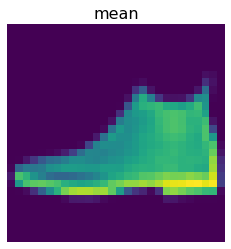

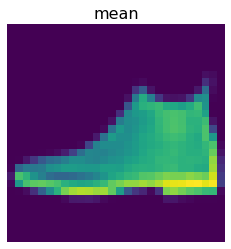

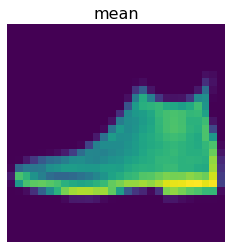

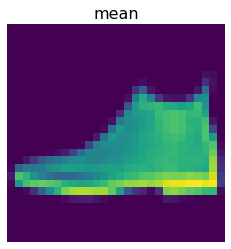

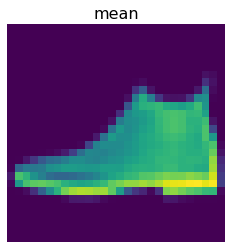

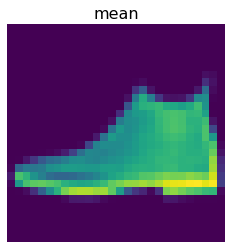

time: 14.676120368639628


In [21]:
begin = time.time()
ii=0
for jj, burnin in enumerate([50,100,500]):
    for nn, numsteps in enumerate([3,5]):
        adaptive_hmc, z_ini, LP = get_kernel(ii,burnin,numsteps)
        samples             = run_chain(adaptive_hmc, z_ini,burnin)
        samples             = np.squeeze(samples.numpy().reshape(-1,params['latent_size']))
        logps               = np.zeros(len(samples))
        for kk in range(len(samples)//params['batch_size']):
            logps[kk*params['batch_size']:(kk+1)*params['batch_size']] = LP.logp(samples[kk*params['batch_size']:(kk+1)*params['batch_size']])
        np.save(os.path.join('/global/cscratch1/sd/vboehm/PAE_samples','HMC_FMNIST_testFMNIST%d_latent_dim%d_burnin%d_leapfrog%d.npy'%(ii, params['latent_size'],burnin,numsteps)),[[logps],samples])
        x_mean              = np.reshape(get_decoded(build_container(samples.mean(axis=0)))[0], (28,28))
        plt.title('mean')
        plt.imshow(x_mean.reshape(28,28))
        plt.axis('off')
        plt.show()
end                 = time.time()-begin
print('time:', end/(jj*nn)/60)

In [24]:
ii = 0
stds  = np.zeros((3,2,params['batch_size']))
means = np.zeros((3,2,params['batch_size']))
for jj, burnin in enumerate([50,100,500]):
    for nn, numsteps in enumerate([3,5]):
        _, samples = np.load(os.path.join('/global/cscratch1/sd/vboehm/PAE_samples','HMC_FMNIST_testFMNIST%d_latent_dim%d_burnin%d_leapfrog%d.npy'%(ii, params['latent_size'],burnin,numsteps)),allow_pickle=True)
        print(samples.shape)
        stds[jj,nn] = np.std(samples,axis=0)
        means[jj,nn] = np.mean(samples,axis=0)

(4992, 64)
(4992, 64)
(4992, 64)
(4992, 64)
(4992, 64)
(4992, 64)


In [35]:
means_ = []
for num in [10,100,1000,1500,2000,2500,3000,3500,4000,4500,-1]:
    means_.append(np.mean(samples[:num,:],axis=0))

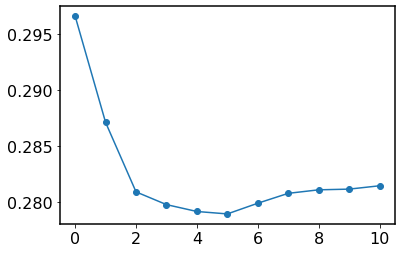

In [37]:
plt.plot(np.asarray(means_)[:,0],marker='o')

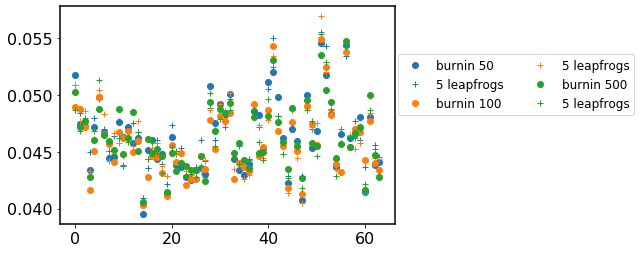

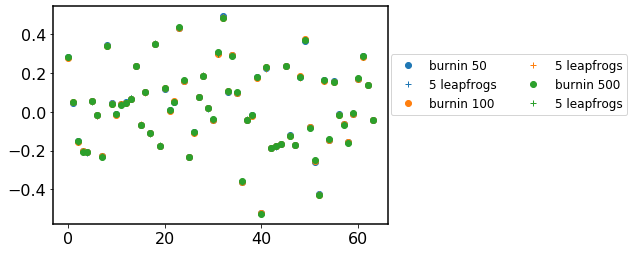

In [28]:
for jj, burnin in enumerate([50,100,500]):
    p = plt.plot(stds[jj,0,:], ls='', marker='o', label='burnin %d'%burnin)
    plt.plot(stds[jj,1,:], ls='', label='5 leapfrogs', marker='+',color=p[0].get_color())
plt.legend(ncol=2,loc=(1.01,0.5))
plt.show()
for jj, burnin in enumerate([50,100,500]):
    p = plt.plot(means[jj,0,:], ls='', marker='o', label='burnin %d'%burnin)
    plt.plot(means[jj,1,:], ls='', label='5 leapfrogs', marker='+',color=p[0].get_color())
plt.legend(ncol=2,loc=(1.01,0.5))

In [38]:
import corner

In [ ]:
corner.corner(samples)
plt.show()

In [ ]:
for ii in range(10):
    for n in [10000]:
        plt.plot(samples[:n,ii])
        plt.show()

In [ ]:


def next_pow_two(n):
    i = 1
    while i < n:
        i = i << 1
    return i

def autocorr_func_1d(x, norm=True):
    x = np.atleast_1d(x)
    if len(x.shape) != 1:
        raise ValueError("invalid dimensions for 1D autocorrelation function")
    n = next_pow_two(len(x))

    # Compute the FFT and then (from that) the auto-correlation function
    f = np.fft.fft(x - np.mean(x), n=2 * n)
    acf = np.fft.ifft(f * np.conjugate(f))[: len(x)].real
    acf /= 4 * n

    # Optionally normalize
    if norm:
        acf /= acf[0]

    return acf



In [ ]:


for ii in range(10):
    for n in [100]:
        acf = autocorr_func_1d(samples[:n,ii], norm=True)
        plt.plot(acf)
        plt.show()



In [ ]:
samples= np.expand_dims(samples,0)

# Automated windowing procedure following Sokal (1989)
def auto_window(taus, c):
    m = np.arange(len(taus)) < c * taus
    if np.any(m):
        return np.argmin(m)
    return len(taus) - 1


# Following the suggestion from Goodman & Weare (2010)
def autocorr_gw2010(y, c=5.0):
    f = autocorr_func_1d(np.mean(y, axis=0))
    taus = 2.0 * np.cumsum(f) - 1.0
    window = auto_window(taus, c)
    return taus[window]


def autocorr_new(y, c=5.0):
    f = np.zeros(y.shape[1])
    for yy in y:
        f += autocorr_func_1d(yy)
    f /= len(y)
    taus = 2.0 * np.cumsum(f) - 1.0
    window = auto_window(taus, c)
    return taus[window]



In [ ]:
N = np.exp(np.linspace(np.log(100), np.log(samples.shape[1]), 20)).astype(int)
gw2010 = np.empty(len(N))
new = np.empty(len(N))
for jj in range(10):
    for i, n in enumerate(N):
        gw2010[i] = autocorr_gw2010(samples[:, :n,jj])
        new[i] = autocorr_new(samples[:, :n,jj])
    tau_esti = np.mean(new[-4:])
    print(tau_esti)

In [ ]:
plt.loglog(N,gw2010)
plt.loglog(N,new, marker='o')
plt.loglog(N, N/50)

In [ ]:
x_mean  = np.reshape(get_decoded(np.repeat([sample_mean],16,0))[0], (28,28))
plt.title('mean')
plt.imshow(x_mean.reshape(28,28))
plt.axis('off')
plt.show()